# BIG DATA - Apprentissage Semi Supervisé
---
Ce TP a pour but de démontré qu'il est possible de faire une selection de variables et que cette dernière est efficace avec de l'apprentissage semi-supervisé.

## Imports et bibliothèque

In [92]:
import math
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

## 1 - Découpage de la base d'apprentissage / test

In [93]:
data = pd.read_csv("Wave.txt", header=None, sep="\s+")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

print("Taille de la base d'apprentissage :", X_train.shape)
print("Taille de la base de test :", X_test.shape)

Taille de la base d'apprentissage : (2500, 40)
Taille de la base de test : (2500, 40)


## 2 - Simulation de l'aspect semi-supervisé

In [94]:
def to_partially_labelled_data(x_train, y_train, percentage):
    X_u, X_l, y_u, y_l = train_test_split(x_train, y_train, test_size=(100 - percentage) / 100, random_state=1, stratify=y_train)
    y_l[:] = -1  # Marquer les étiquettes non étiquetées avec -1
    return np.concatenate((X_u, X_l)), np.concatenate((y_u, y_l))


percentage = 70
new_X_train, new_y_train = to_partially_labelled_data(X_train, y_train, percentage)
print("Nombre d'exemples étiquetés :", new_y_train[new_y_train != -1].shape[0])
print("Nombre d'exemples non étiquetés :", new_y_train[new_y_train == -1].shape[0])

Nombre d'exemples étiquetés : 1750
Nombre d'exemples non étiquetés : 750


Nous avons decidé de délabelisé nos données en remplaçant la classe par -1 et nos avons bien pensé à stratifier.

Dans cet exemple, nous avons choisis un pourcentage de 70% et on vérifie bien que le nombre d'exemples étiquetés est de 1750 (70% de 2500).
Dans la suite du tp (sauf la dernière question), on utiliserait cette repartition 70% labelisée, 30 % non labelisée.

## 3 - Sélection de variables semi-supervisées

In [95]:
def calculate_variable_pertinence_score(data, indexVariable):
    data_labelled = data[data[:, -1] != -1]
    data_unlabelled = data[data[:, -1] == -1]
    
    s1 = calculate_s1(data_labelled, indexVariable) 
    # print("Score s1 : ",s1)
    s2 = calculate_s2(data_unlabelled, indexVariable)    
    # print("Score s2", s2)
    
    return s1 / s2


def calculate_s1(data, indexVariable):
    effectif_classes = get_effectif_classes(data)
    mean_by_classes = get_mean_variable_classes(data, indexVariable)
    ecart_type_by_classes = get_ecart_type_variable_classes(data, indexVariable)
    mean_all_base = get_mean_all_base_variable(data, indexVariable)

    numerateur = 0
    denominateur = 0
    
    for i in range(len(effectif_classes)):
        numerateur += effectif_classes[i] * (mean_by_classes[i] - mean_all_base)**2
        denominateur += effectif_classes[i] * ecart_type_by_classes[i]**2
        
    return numerateur / denominateur


def calculate_s2(data, indexVariable):
    # on parcours toutes les valeurs de la colonne variable
    colonne = data[:, indexVariable]
    numerateur = 0
    # denominateur est égal à la variance de la variable
    denominateur = get_variance_all_base_variable(data, indexVariable)
    for i in range(len(colonne)):
        for j in range(len(colonne)):
            diff_vals = (colonne[i] - colonne[j])**2
            numerateur += diff_vals * get_sum_line(data[i], data[j])
    
    return numerateur / denominateur


def get_effectif_classes(data):
    # on récupère la liste des différents labels du tableau
    classes = np.unique(data[:,-1])
    # on compte pour chaque classe le nombre d'occurences
    effectifs = np.zeros(len(classes))
    for i in range(len(classes)):
        effectifs[i] = np.sum(data[:,-1] == classes[i])
    return effectifs


def get_mean_variable_classes(data, variable):
    classes = np.unique(data[:,-1])
    # on compte pour chaque classe le nombre d'occurences
    moyennes = np.zeros(len(classes))
    for i in range(len(classes)):
        lignes_classe = data[data[:, -1] == classes[i]]
        valeurs_variable_classe = lignes_classe[:, variable]
        moyennes[i] = np.mean(valeurs_variable_classe)
    
    return moyennes

def get_mean_all_base_variable(data, variable):
    valeurs_variable_classe = data[:, variable]
    moyenne = np.mean(valeurs_variable_classe)
        
    return moyenne

def get_ecart_type_variable_classes(data, variable):
    classes = np.unique(data[:,-1])
    # on compte pour chaque classe le nombre d'occurences
    ecart_types = np.zeros(len(classes))
    for i in range(len(classes)):
        lignes_classe = data[data[:, -1] == classes[i]]
        valeurs_variable_classe = lignes_classe[:, variable]
        ecart_types[i] = np.std(valeurs_variable_classe)
    
    return ecart_types

def get_variance_all_base_variable(data, variable):
    valeurs_variable_classe = data[:, variable]
    variance = np.var(valeurs_variable_classe)
        
    return variance

def get_sum_line(line_i, line_j):
    t = 10
    return math.exp(-(np.linalg.norm(line_i - line_j) / t))

# on concatène les variables avec les étiquettes
data = np.concatenate((new_X_train, new_y_train.reshape(-1, 1)), axis=1)


## 4 - Évaluation de la sélection

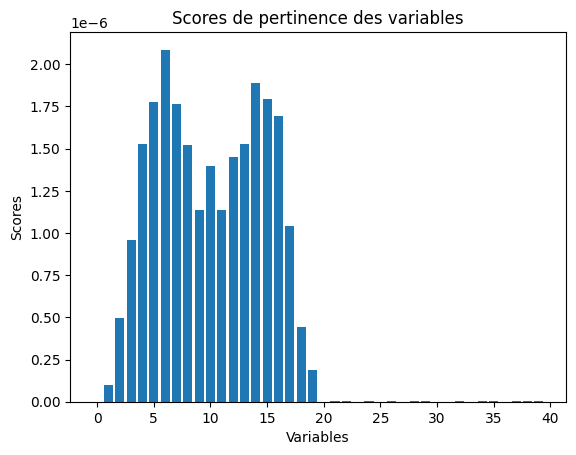

In [96]:
results = np.zeros(data.shape[1]-1)
for i in range(data.shape[1]-1):
    results[i] = calculate_variable_pertinence_score(data, i)
    
# On trace l'histogramme des scores de pertinence
plt.bar(range(data.shape[1]-1), results)
plt.title("Scores de pertinence des variables")
plt.xlabel("Variables")
plt.ylabel("Scores")
plt.show()


L'histogramme ci-dessus présente les scores de pertinence de chaque variables que nous avons calculé précédemment.
On peut voir que les 20 premières variables influe beaucoup sur les données tandis que les 20 suivantes ne sont vraiment pas pertinentes et peuvent meme fausser les resultats en provoquant du bruit.

Plus précisment parmis les 20 premières variables (les plus pertinentes), on remarque que les variables 4,5,6,7,14,15 et 16 sont les plus pertinentes parmi les 20 plus pertinentes.

In [97]:
# Pour chaque tranche de 5 variables, on entraîne un modèle MLP et on évalue ses performances
def print_perf_mlp_on_variable(number_of_variables, normalized, x_train, x_test, y_train, y_test, sorted_indexes, plot_title):
    performances = []

    if normalized:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    mlp = MLPClassifier(hidden_layer_sizes=(20,20), random_state=1)
    for i in range(1, len(sorted_indexes) // 5 + 1):  # On commence à 1 pour la première tranche de 5 variables
        # On sélectionne les variables les plus pertinentes
        selected_variables = sorted_indexes[:5*i]  # Sélectionne les 5 premières, puis 10, puis 15, ...
        # print("Variables sélectionnées : ", selected_variables)
        # On entraîne le modèle
        mlp.fit(x_train[:, selected_variables], y_train)
        # On évalue les performances
        y_pred = mlp.predict(x_test[:, selected_variables])
        accuracy = accuracy_score(y_test, y_pred)
        # print("Accuracy : ", accuracy)
        performances.append(accuracy)

    # On trace les performances
    plt.plot(range(5, len(performances)*5+1, 5), performances)
    plt.title(plot_title)
    plt.xlabel("Nombre de variables")
    plt.ylabel("Accuracy")
    plt.show()

Nous avons décidé d'utiliser le dataset de base pour entraîner les modèles, car les performances sont meilleures que celles obtenues avec le dataset partiellement étiqueté. En effet, les performances obtenues avec le dataset partiellement étiqueté sont très faibles, car le modèle n'a pas assez d'informations pour apprendre correctement. En effet, le dataset partiellement étiqueté ne contient que 70% d'exemples étiquetés, ce qui est très peu. Les performances obtenues avec le dataset de base sont bien meilleures, car le modèle a plus d'informations pour apprendre. D'autant plus que le but du tp est de pouvoir identifié les meilleures variables dans un cas d'apprentissage supervisé. On utilise le dataset complet que pour faire apprendre le mlp. On pourrait aussi le faire en utilisant seulement les données labelisé de notre dataset après transformation.

### Courbe avec données en triant par variables les plus pertinentes (non-normalisées)

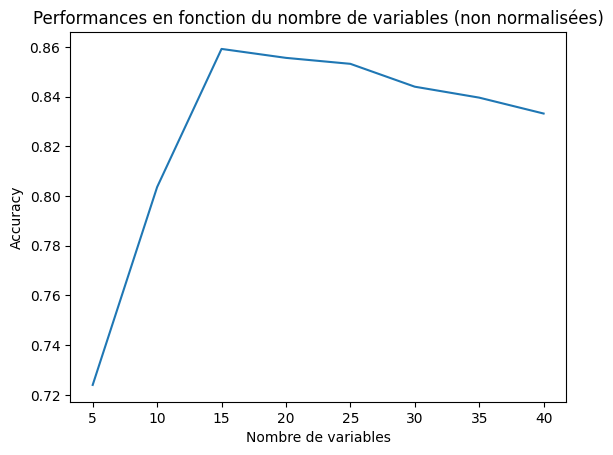

In [98]:
# Affichage des perfs 5 à 5 pour les variables non normalisées
print_perf_mlp_on_variable(5, False, X_train, X_test, y_train, y_test, np.argsort(-results), "Performances en fonction du nombre de variables (non normalisées)")

Avec le graphique ci-dessus, on peut voir l'évolution de l'accuracy selon le nombre de variables (triées par pertinence).
Avec toutes les variables soit 40, on peut voir qu'on a une accuracy d'environ 84 %.

On s'aperçoit que 40 variables ne permet d'obtenir la meilleur accuracy. En effet, c'est avec 15 variables que l'on obtient la meilleure accuracy soit 86 %. Nous sommes donc debarrassé de plus de la moitié des variables soit 25 pour en plus améliorer notre accuracy.

En regardant la courbe plus largement, nous pouvons constater qu'avec 5 variables nous sommes à une accuracy de 72 %. Et cette accuracy augmente proportionnellement avec le nombre de variables jusqu'à 15 variables (notre maximum). A l'inverse, en partant de maximum l'accuracy diminue plus on augmente le nombre de variable.

Même si avec 40 variables nous avons quand même une bonne accuracy (84% proche de 86%), on peut en déduire que garder trop de variables fait baisser l'accuracy et créer donc du bruit qui ne permet pas au MLP d'apprendre de manière optimale.

### Courbe avec données en triant par variables les plus pertinentes (normalisées)

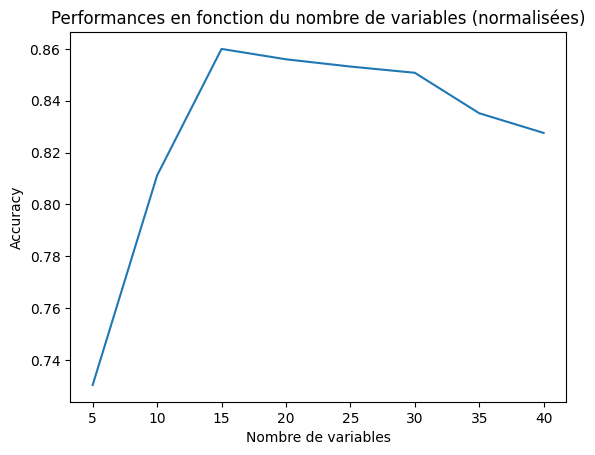

In [99]:
# Affichage des perfs 5 à 5 pour les variables normalisées
print_perf_mlp_on_variable(5, True, X_train, X_test, y_train, y_test, np.argsort(-results), "Performances en fonction du nombre de variables (normalisées)")

En normalisant les données on ne constate aucun changement significatif si ce n'est que : 
* Avec 5 variables, on a 75 % d'accuracy et pas 72 %. Et donc les accuracy sont legerement meilleure (+/- 1% jusqu'a 15 variables).
* Avec 40 variables, on a 83% d'accuracy et pas 82%.

### Courbe avec données en triant par variables les moins pertinentes (normalisées)

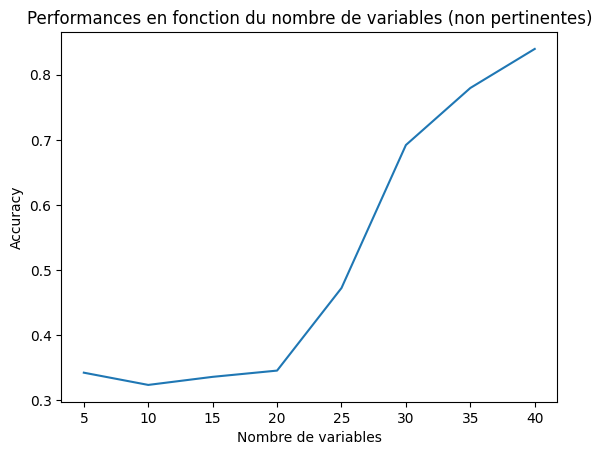

In [100]:
# Affichage des perfs 5 à 5 pour les variables non pertinentes
print_perf_mlp_on_variable(5, True, X_train, X_test, y_train, y_test, np.argsort(results), "Performances en fonction du nombre de variables (non pertinentes)")

Pour cette courbe, on remarque que plus on augmente le nombre de variables plus on a une meilleure accuracy.
Ce qui parait logique puisque les variables les plus pertinentes sont les 20 dernières dans cette configuration.

### Courbe avec données en ne triant pas les variables (normalisées)

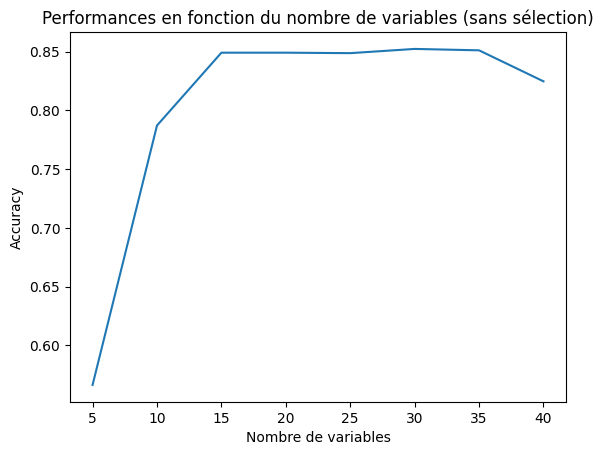

In [101]:
# Affichage sans sélection de variables
print_perf_mlp_on_variable(5, True, X_train, X_test, y_train, y_test, np.arange(0, new_X_train.shape[1]), "Performances en fonction du nombre de variables (sans sélection)")

Dans ce graphique, on remarque que le nombre de varaibles qui maximisent l'accuracy est de choisir un nombre enre 25 et 35. 
En effet, la courbe ne change pas entre ces deux nombres.

En partant de 5 on voit que l'accuracy augmente lorsque l'on augmente le nombre de variables jusqu'a atteindre 35.
A partir de 35, on remarque que l'accuracy ne fait que diminuer jusqu'a 40.

Ainsi, on peut conclure que les données dans le dataset de base ne sont pas ordonnée de la manière la plus optimale si l'on ne veut que garder les variables les plus pertinentes. 

### Courbe en fonction du pourcentage de données étiquetées (normalisées)

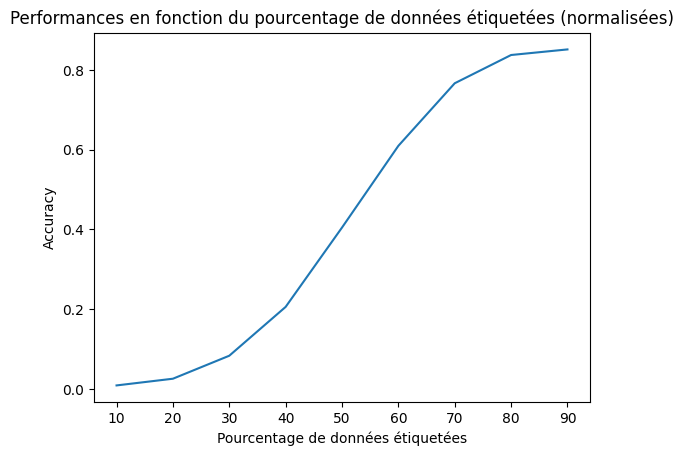

In [102]:
# on fixe le nombre de variables à 20 et on fait varier le pourcentage de données étiquetées

def print_perf_mlp_on_percentage(number_of_variables, normalized, x_train, x_test, y_train, y_test, sorted_indexes, plot_title):
    performances = []

    if normalized:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    mlp = MLPClassifier(hidden_layer_sizes=(20,20), random_state=1)
    for i in range(10, 100, 10):
        new_X_train, new_y_train = to_partially_labelled_data(x_train, y_train, i)
        mlp.fit(new_X_train[:, sorted_indexes[:number_of_variables]], new_y_train)
        y_pred = mlp.predict(x_test[:, sorted_indexes[:number_of_variables]])
        accuracy = accuracy_score(y_test, y_pred)
        performances.append(accuracy)

    plt.plot(range(10, 100, 10), performances)
    plt.title(plot_title)
    plt.xlabel("Pourcentage de données étiquetées")
    plt.ylabel("Accuracy")
    plt.show()

# On affiche de 0 à 100% de 10 à 10 dans une boucle
print_perf_mlp_on_percentage(20, True, X_train, X_test, y_train, y_test, np.argsort(-results), "Performances en fonction du pourcentage de données étiquetées (normalisées)")

On remarque sur le graphique ci-dessus que plus on augmente le nombre de données etiquetés plus on a une meilleure accuracy. Ce qui paraît totalement logique, plus on a de données sur lesquels apprendre plus on va pouvoir être précis sur notre selection de variables et donc avoir une meilleur accuracy au final.